In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from adjustText import adjust_text
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_rows', None)

In [2]:
TARGET = 'Centre-Back'
N_MOST_SIMILAR_PLAYERS = 50

In [3]:
DATA_DIR = './Leagues'

CB = [
        'age',
        # 'Yel',
        # 'Red',
        'Inter',
        'Offsides',
        'Clear',
        'Dribbles allowed',
        'Blocks',
        'OwnGoal',
        'Foul_given_game',
        'Dispossessed_per_game',
        'Unsuccessful touches',
        # 'Average_per_pass',
        # 'Shortpass_per_game',   
]

RB = [
        'age',
        # 'Yel',
        # 'Red',
        'Inter',
        'Offsides',
        'Clear',
        'Dribbles allowed',
        'Blocks',
        'OwnGoal',
        'Foul_given_game',
        'Dispossessed_per_game',
        'Unsuccessful touches',   
        # 'Average_per_pass',
        'Shortpass_per_game',
        'Crosses_per_game',
        'Longpass_per_game',
    ]

LB = [
        'age',
        # 'Yel',
        # 'Red',
        'Inter',
        'Offsides',
        'Clear',
        'Dribbles allowed',
        'Blocks',
        'OwnGoal',
        'Foul_given_game',
        'Dispossessed_per_game',
        'Unsuccessful touches',
        # 'Average_per_pass',
        'Shortpass_per_game',
        'Crosses_per_game',
        'Longpass_per_game',
]

CM = [
        'age',
        # 'Yel',
        # 'Red',
        'SpG',
        'Key_pass_per_game',
        'Dribble',
        # 'Average_per_pass',
        'Shortpass_per_game',
        'Longpass_per_game',
        'Through_ball_per_game',
]

CAM = [
        'age',
        # 'Yel',
        # 'Red',
        'SpG',
        'Key_pass_per_game',
        'Dribble',
        # 'Average_per_pass',
        'Shortpass_per_game',
        'Longpass_per_game',
        'Through_ball_per_game',
        'xG',
        'xGDiff',
        'xGPerNinety',
        'totalShots',
        'xGPerShot',
        'Dispossessed_per_game',
        'Unsuccessful touches',
        # 'Average_per_pass',
        'Shortpass_per_game',
]

CDM = [
        'age',
        # 'Yel',
        # 'Red',
        'Inter',
        'Offsides',
        'Clear',
        'Dribbles allowed',
        'Blocks',
        'Foul_given_game',
        'Dispossessed_per_game',
        'Unsuccessful touches',
        'Key_pass_per_game',
        'Dribble',
        # 'Average_per_pass',
        'Shortpass_per_game',
        'Longpass_per_game',
        'Through_ball_per_game',
]


ST = [
        'age',
        # 'Yel',
        # 'Red',
        'SpG',
        'Dribble',
        'xG',
        'xGDiff',
        'xGPerNinety',
        'totalShots',
        'xGPerShot',
        'Dispossessed_per_game',
        'Unsuccessful touches',
        # 'Average_per_pass',
        'Shortpass_per_game',
    ]

LW = [
        'age',
        # 'Yel',
        # 'Red',
        'SpG',
        'Dribble',
        'xG',
        'xGDiff',
        'xGPerNinety',
        'totalShots',
        'xGPerShot',
        'Dispossessed_per_game',
        'Unsuccessful touches',
        # 'Average_per_pass',
        'Shortpass_per_game',
        'Crosses_per_game',
        'Longpass_per_game',
    ]

RW = LW
LM = LW
RM = LW


## 포지션별 스탯
STATS_PER_POSITION = {
    'Goalkeeper' : ['Total_Saves', 'SixYardBox_Saves', 'PenaltyArea_Saves', 'OutOfBox_Saves', 'age'],
    'Centre-Back' : CB,
    'Right-Back' : RB,
    'Left-Back' : LB,
    'Central Midfield' : CM,
    'Left Midfield' : LM,
    'Right Midfield' : RM,
    'Defensive Midfield' : CDM,
    'Attacking Midfield' : CAM,
    'Left Wing' : LW,
    'Right Wing' : RW,
    'Centre-Forward' : ST
}


In [4]:
players_stats = pd.read_csv(f'{DATA_DIR}/all_players_stats.csv', encoding='utf-8')
players_values = pd.read_csv(f'{DATA_DIR}/all_players_values.csv', encoding='utf-8')
players_details = pd.read_csv(f'{DATA_DIR}/all_players_stats_details.csv', encoding='utf-8')

teams_stats = pd.read_csv(f'{DATA_DIR}/all_teams_stats.csv', encoding='utf-8')
teams_values = pd.read_csv(f'{DATA_DIR}/all_teams_values.csv', encoding='utf-8')

In [5]:
def convert_market_value(value):
    if pd.isna(value):
        return None
    value = value.replace('€', '').strip().lower()
    if 'm' in value:
        return float(value.replace('m', '')) * 1_000_000
    elif 'k' in value:
        return float(value.replace('k', '')) * 1_000
    try:
        return float(value)
    except ValueError:
        return None

players_values['Market Value'] = players_values['Market Value'].apply(convert_market_value)

In [6]:
players_details_reduced = players_details.drop(columns=['player_name', 'team_name'])
players_totals = players_stats.merge(players_details_reduced, left_index=True, right_index=True, how='left')

players_values_reduced = players_values.drop(columns=['Team', 'Position', 'Date of Birth', 'Age', 'Nationality'])
players_values_reduced.rename(columns={'Name': 'player_name'}, inplace=True)
players_totals = players_totals.merge(players_values_reduced, on='player_name', how='left')

players_totals.rename(columns={
    'Red_x': 'Red', 
    'Fouls_y' : 'Fouls', 
    'Yellow' : 'Yel_x',
    'Short' : 'Shortpass_per_game',
    'Unsuccessful' : 'Unsuccessful_Dribbles',
    'Successful' : 'Successful_Dribbles'
}, inplace=True)
players_totals = players_totals[[col for col in players_totals.columns if not col.endswith('_x') and not col.endswith('_y')]]

players_totals['team_name'] = players_totals['team_name'].fillna('')
players_totals.drop_duplicates(subset=['player_name', 'team_name'], inplace=True)

# players_totals.to_csv('./Leagues/all_players_stats_total.csv', index=False)
# players_totals.head(10)

In [7]:
def group_top_teams_by_position(all_players_stats, all_teams_stats):
    all_teams_stats['Pts'] = pd.to_numeric(all_teams_stats['Pts'])
    top_teams = all_teams_stats.nlargest(15, 'Pts')['team_name'].tolist()
    top_teams_df = all_players_stats[
        (all_players_stats['team_name'].isin(top_teams)) &
        (all_players_stats['Apps'].apply(lambda x: int(x.split('(')[0]) if pd.notna(x) else 0) >= 15)
    ].copy()
    top_teams_df['positions'] = top_teams_df['position'].apply(lambda x: [pos.strip() for pos in x.split(',') if pd.notna(x)])
    all_positions = set(pos for positions in top_teams_df['positions'] for pos in positions)
    position_groups = {pos: [] for pos in all_positions}
    for _, row in top_teams_df.iterrows():
        player_name = row['player_name']
        player_positions = row['positions']
        for pos in player_positions:
            position_groups[pos].append(player_name)
    return position_groups, top_teams


def group_lower_teams_by_position_per_league(all_players_stats, all_teams_stats):
    all_teams_stats['Pts'] = pd.to_numeric(all_teams_stats['Pts'])
    excluded_teams_per_league = all_teams_stats.groupby('League').apply(lambda x: x.nlargest(3, 'Pts')['team_name']).tolist()
    position_groups = {}
    for league in all_teams_stats['League'].unique():
        lower_teams = all_teams_stats[
            (all_teams_stats['League'] == league) &
            (~all_teams_stats['team_name'].isin(excluded_teams_per_league))
        ]['team_name'].tolist()
        lower_teams_df = all_players_stats[
            (all_players_stats['team_name'].isin(lower_teams)) &
            (all_players_stats['Apps'].apply(lambda x: int(x.split('(')[0]) if pd.notna(x) else 0) >= 15)
        ]
        for _, row in lower_teams_df.iterrows():
            positions = [pos.strip() for pos in row['position'].split(',') if pd.notna(row['position'])]
            player_name = row['player_name']
            for pos in positions:
                if pos in position_groups:
                    position_groups[pos].append(player_name)
                else:
                    position_groups[pos] = [player_name]
    return position_groups

In [8]:
def find_similar_players(top_players_stats, top_position_groups, bottom_players_stats, bottom_position_groups, position, n=10):
    top_players_stats_filtered = top_players_stats[top_players_stats['player_name'].isin(top_position_groups[position])]
    bottom_players_stats_filtered = bottom_players_stats[bottom_players_stats['player_name'].isin(bottom_position_groups[position])]
    
    stat_columns = STATS_PER_POSITION[position]
    imputer = SimpleImputer(strategy='mean')
    top_players_stats_imputed = imputer.fit_transform(top_players_stats_filtered[stat_columns])
    top_players_avg_stats = top_players_stats_imputed.mean(axis=0).reshape(1, -1)
    bottom_players_stats_imputed = imputer.transform(bottom_players_stats_filtered[stat_columns])
    
    similarity_scores = cosine_similarity(bottom_players_stats_imputed, top_players_avg_stats)
    most_similar_indices = similarity_scores.flatten().argsort()[::-1][:n]
    most_similar_players = bottom_players_stats_filtered.iloc[most_similar_indices]
    
    return most_similar_players, similarity_scores.flatten()[most_similar_indices]

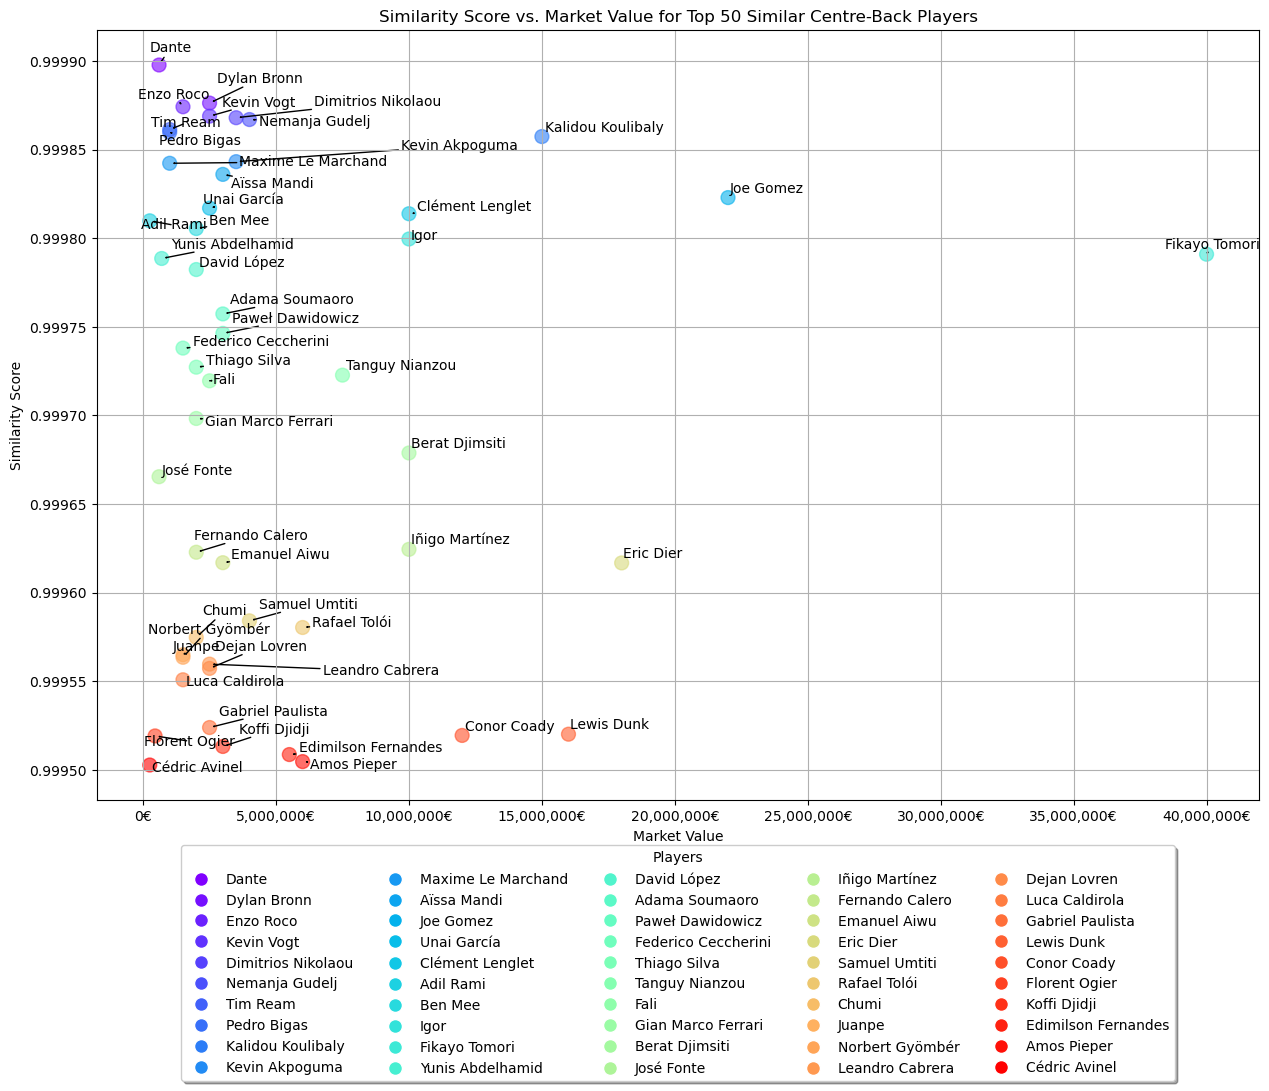

In [9]:
top_position_groups, top_teams = group_top_teams_by_position(players_totals, teams_stats)
bottom_position_groups = group_lower_teams_by_position_per_league(players_totals, teams_stats)

top_players_stats = players_totals[players_totals['team_name'].isin(top_teams)]
bottom_players_stats = players_totals[~players_totals['team_name'].isin(top_teams)]

most_similar_players, similarity_scores = find_similar_players(top_players_stats, top_position_groups, bottom_players_stats, bottom_position_groups, TARGET, N_MOST_SIMILAR_PLAYERS)

top_players_stats_filtered = top_players_stats[top_players_stats['player_name'].isin(top_position_groups[TARGET])]
similar_players_stats = bottom_players_stats[bottom_players_stats['player_name'].isin(most_similar_players['player_name'])]

plot_data = most_similar_players[['player_name', 'Market Value']].copy()
plot_data['Similarity Score'] = similarity_scores
plot_data.dropna(subset=['Market Value', 'Similarity Score'], inplace=True)

unique_players = plot_data['player_name'].unique()
color_map = plt.cm.get_cmap('rainbow', len(unique_players))
player_colors = {player: color_map(i) for i, player in enumerate(unique_players)}

plt.figure(figsize=(15, 10))
scatter = plt.scatter(x=plot_data['Market Value'], y=plot_data['Similarity Score'], s=100, c=[player_colors[name] for name in plot_data['player_name']], alpha=0.6)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in player_colors.values()]
plt.legend(handles, player_colors.keys(), title='Players', loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

texts = []
for i, row in plot_data.iterrows():
    texts.append(plt.text(row['Market Value'], row['Similarity Score'], row['player_name']))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}€'.format(x)))

plt.xlabel('Market Value')
plt.ylabel('Similarity Score')
plt.title(f'Similarity Score vs. Market Value for Top {N_MOST_SIMILAR_PLAYERS} Similar {TARGET} Players')
plt.grid(True)
plt.show()

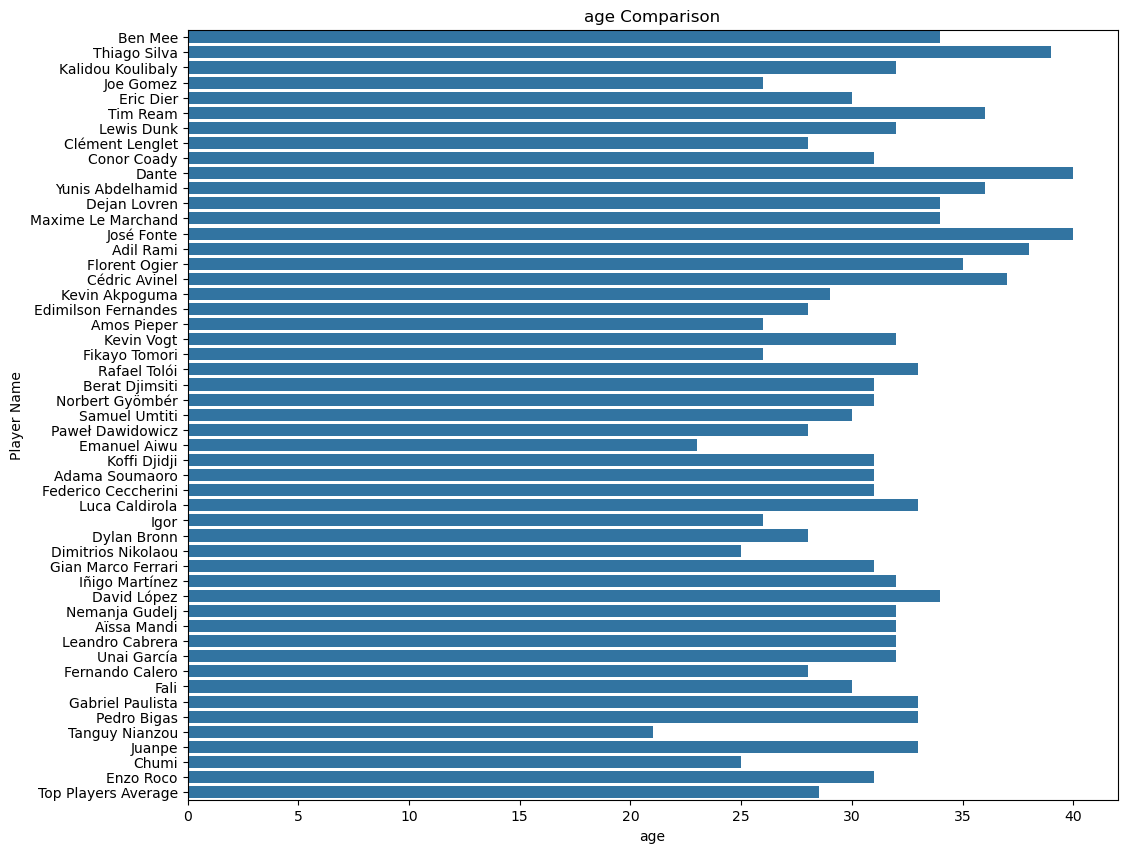

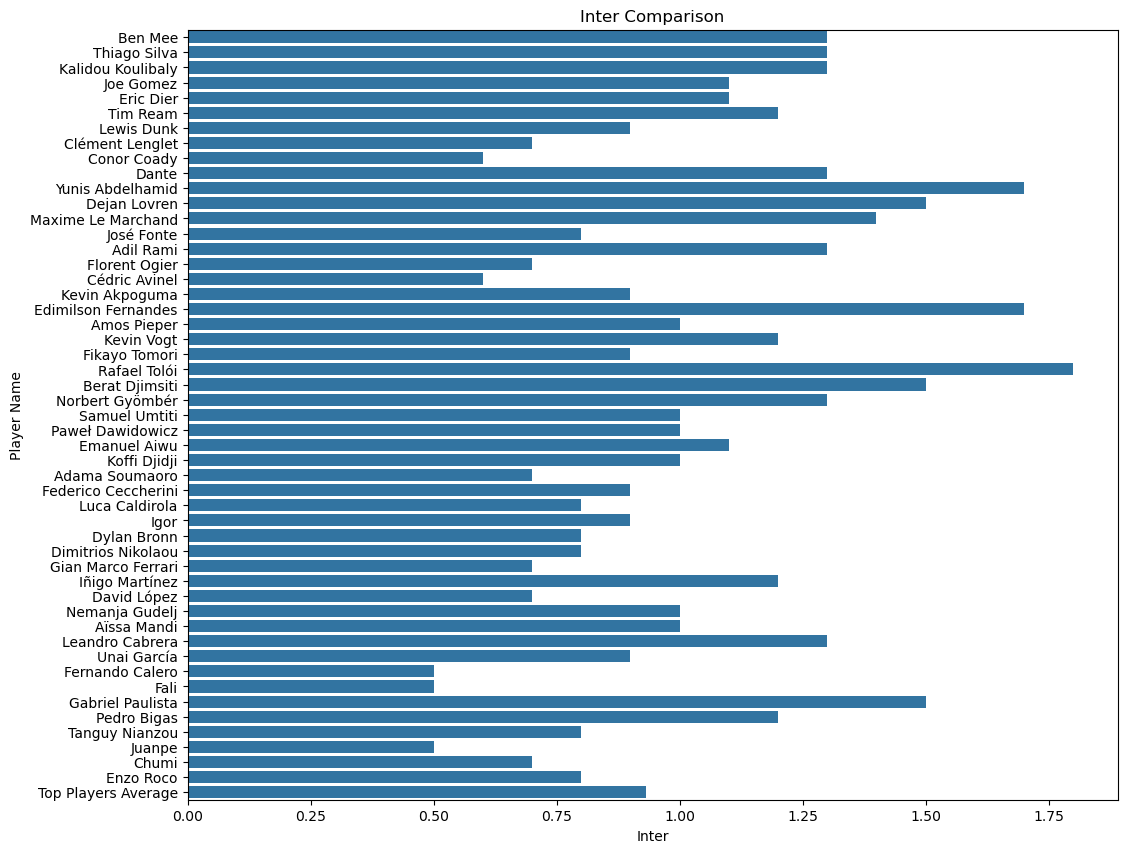

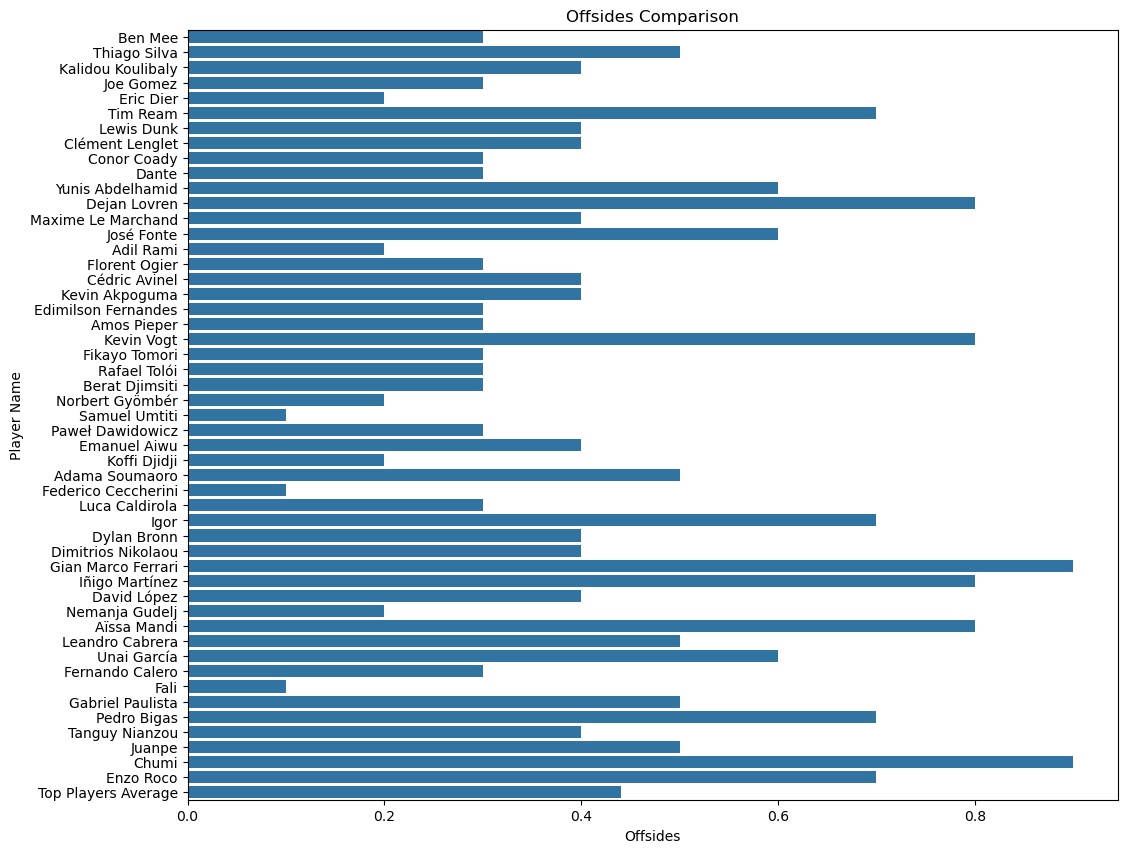

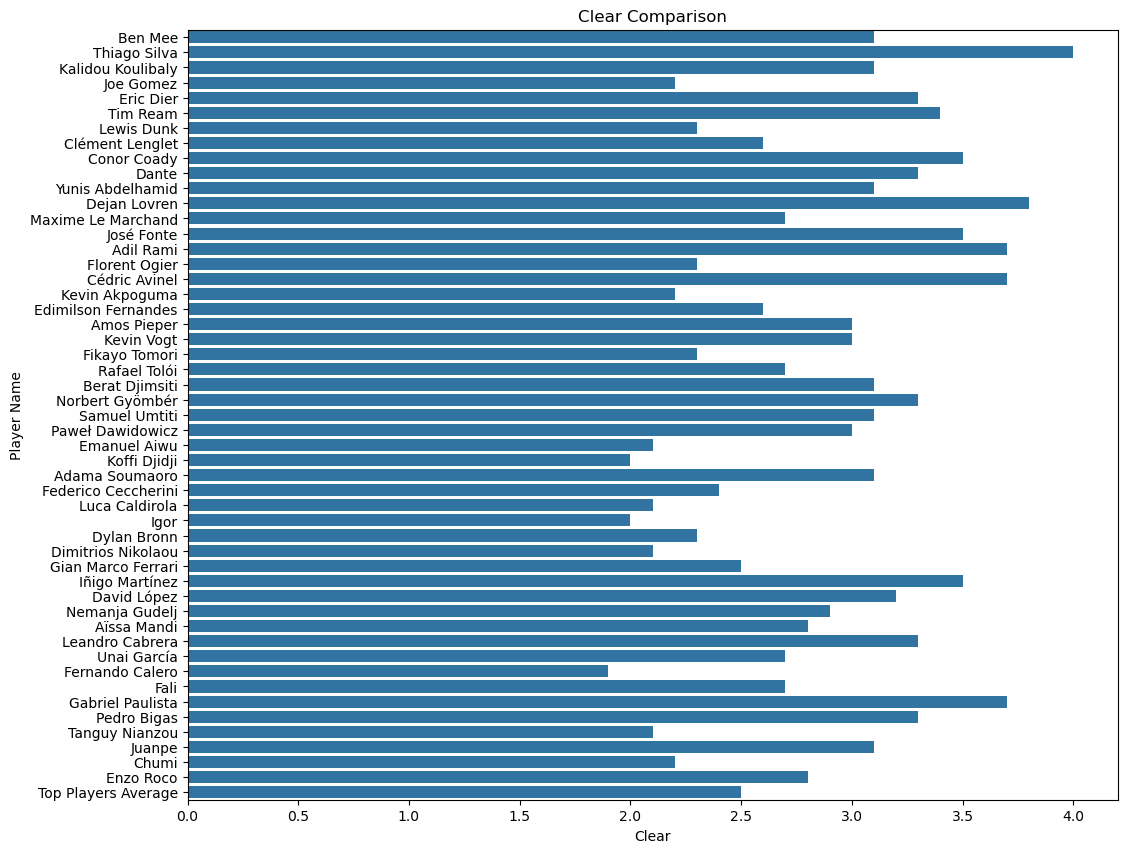

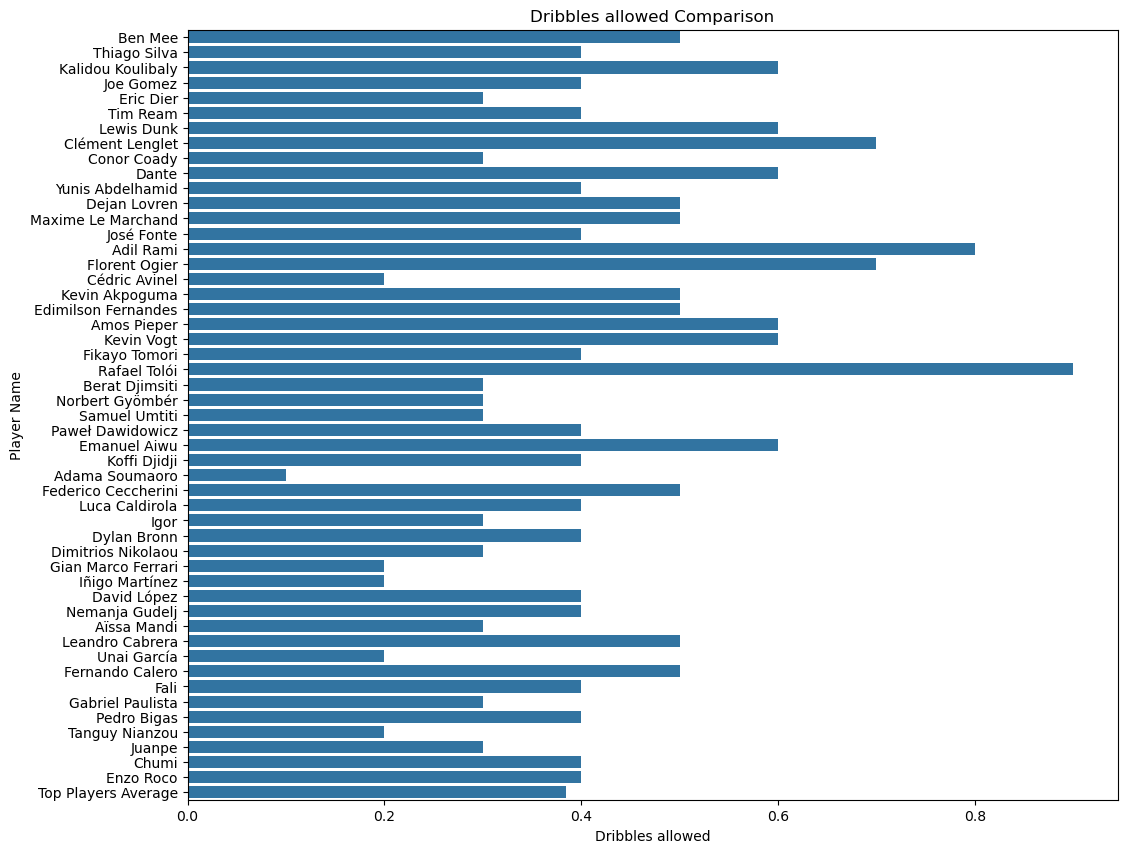

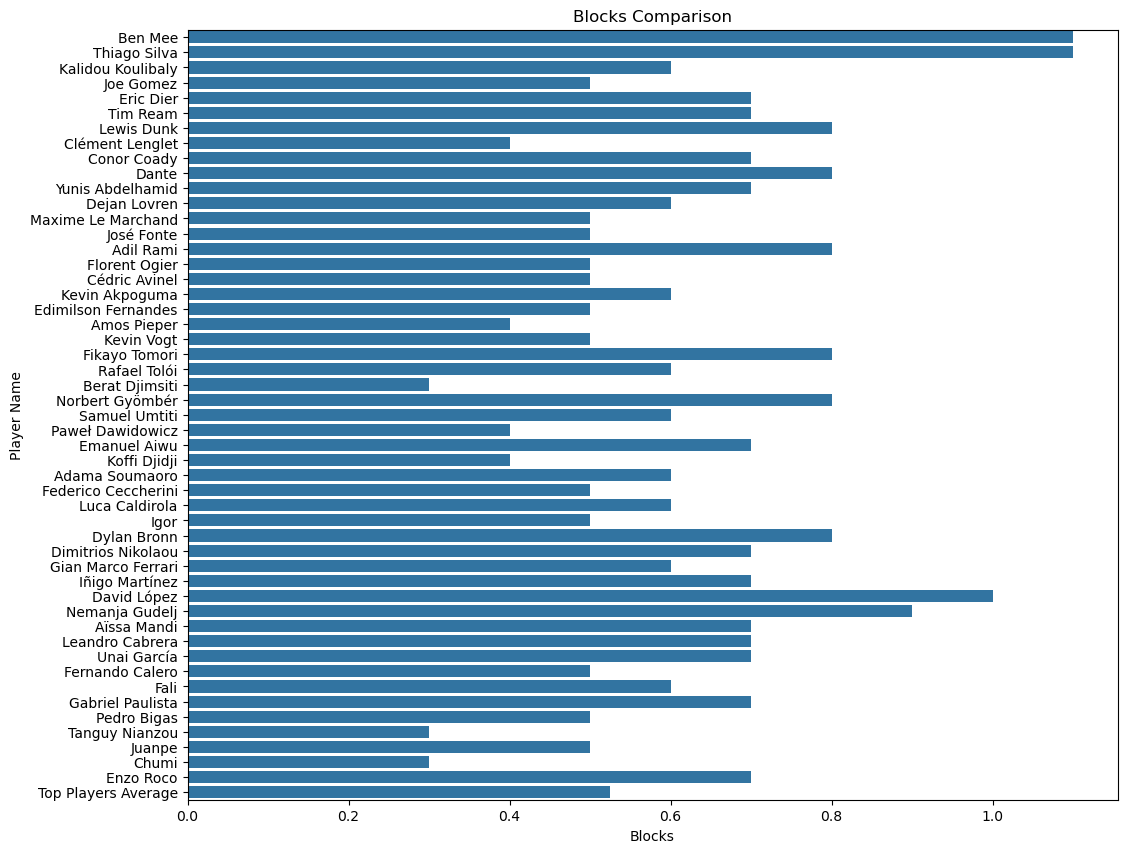

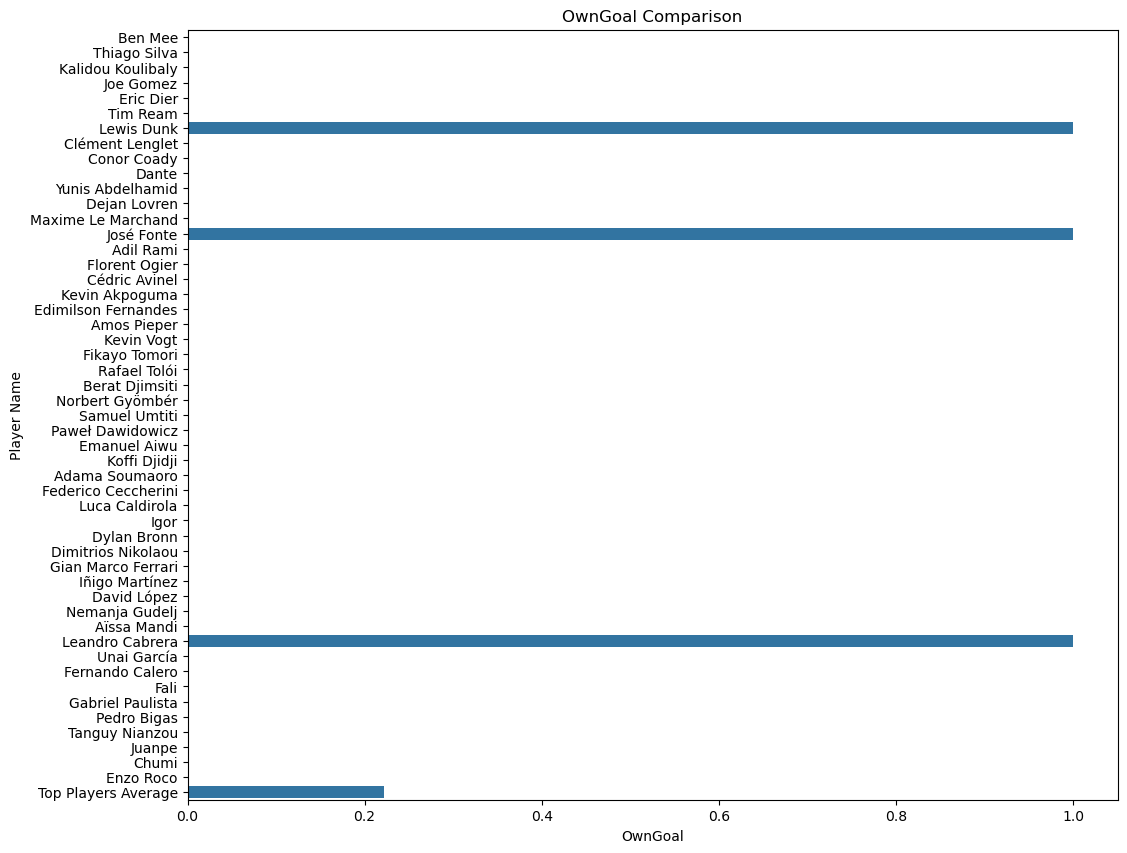

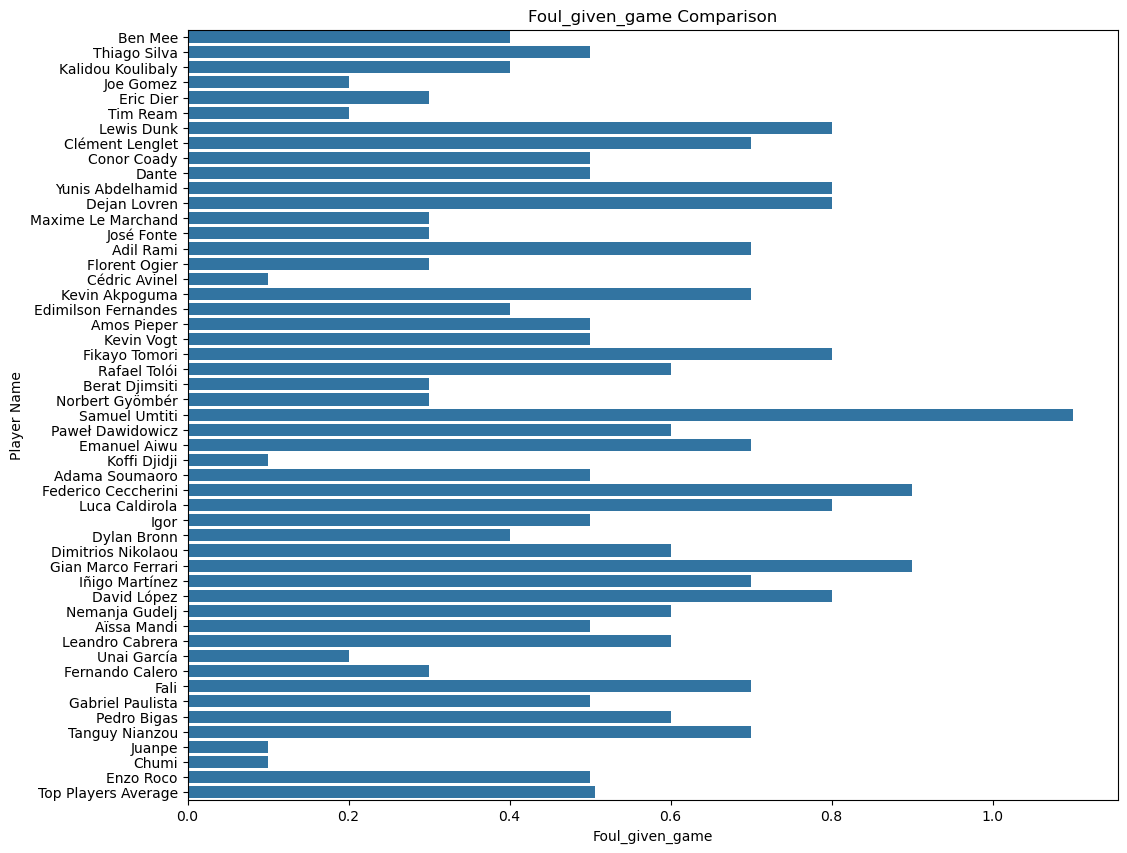

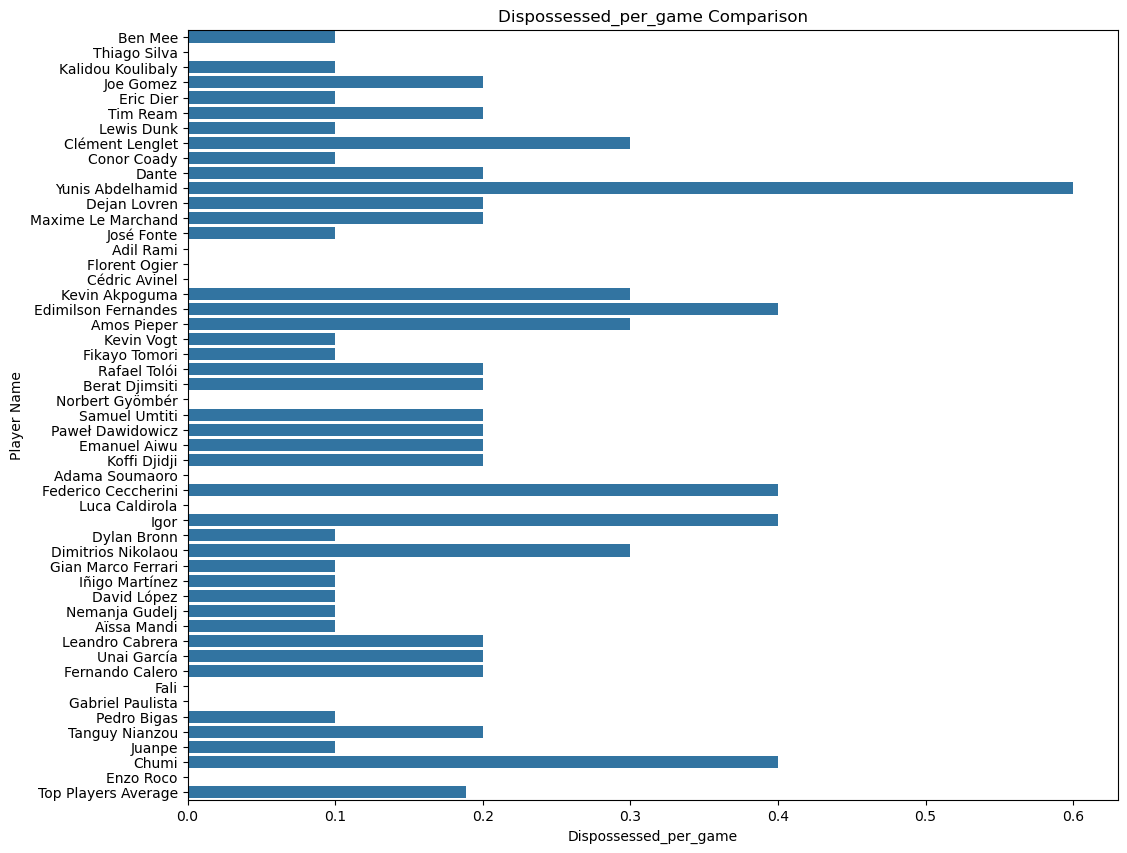

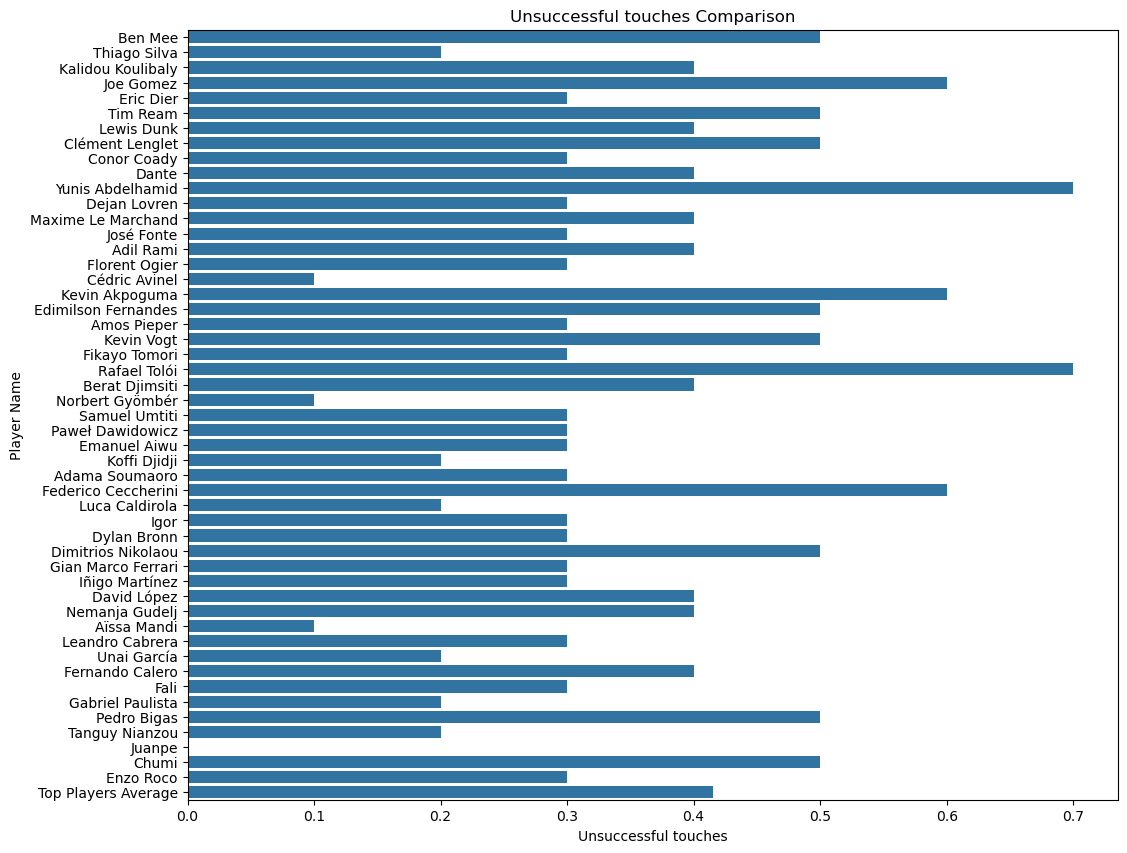

In [10]:
stat_columns = STATS_PER_POSITION[TARGET] 

## Top Players Average 계산
top_players_avg_stats = top_players_stats_filtered[stat_columns].mean()
top_players_avg_stats = pd.DataFrame(top_players_avg_stats).T
top_players_avg_stats.columns = stat_columns
top_players_avg_stats['player_name'] = 'Top Players Average'

## 전체 컬럼에 대한 DataFrame 생성
full_columns = similar_players_stats.columns
top_players_avg_stats_full = pd.DataFrame(columns=full_columns)

for col in top_players_avg_stats.columns:
    if col in top_players_avg_stats_full.columns:
        top_players_avg_stats_full[col] = top_players_avg_stats[col].values

for col in top_players_avg_stats_full.columns:
    if col not in top_players_avg_stats.columns:
        top_players_avg_stats_full[col] = 0 if similar_players_stats[col].dtype.kind in 'biufc' else 'Unknown'

top_players_avg_stats_full = top_players_avg_stats_full.reset_index(drop=True)
combined_stats = pd.concat([similar_players_stats, top_players_avg_stats_full], ignore_index=True)

for col in stat_columns:
    if col in combined_stats.columns:
        plt.figure(figsize=(12, 10))
        sns.barplot(data=combined_stats, x=col, y='player_name', errorbar=None)
        plt.title(f'{col} Comparison')
        plt.xlabel(col)
        plt.ylabel('Player Name')
        plt.show()

In [11]:
print("stat_columns:")
print(stat_columns)
print("\nsimilar_players_stats.columns:")
print(similar_players_stats.columns)

stat_columns:
['age', 'Inter', 'Offsides', 'Clear', 'Dribbles allowed', 'Blocks', 'OwnGoal', 'Foul_given_game', 'Dispossessed_per_game', 'Unsuccessful touches']

similar_players_stats.columns:
Index(['player_name', 'team_name', 'age', 'position', 'Apps', 'Mins', 'Goals',
       'Assists', 'Yel', 'Red', 'SpG', 'PS%', 'AerialsWon', 'MoM', 'Rating',
       'Tackles', 'Inter', 'Offsides', 'Clear', 'Dribbles allowed', 'Blocks',
       'OwnGoal', 'Key_pass_per_game', 'Dribble', 'Foul_given_game',
       'Offside_given_per_game', 'Dispossessed_per_game',
       'Unsuccessful touches', 'Average_per_pass', 'Crosses_per_game',
       'Longpass_per_game', 'Through_ball_per_game', 'xG', 'xGDiff',
       'xGPerNinety', 'totalShots', 'xGPerShot', 'TotalTackles',
       'DribbledPast', 'TotalAttemptedTackles', 'Total_Interception', 'Fouled',
       'Fouls', 'CaughtOffside', 'Total_Clearances', 'ShotsBlocked',
       'CrossesBlocked', 'PassesBlocked', 'Total_Saves', 'SixYardBox_Saves',
       'Penalty

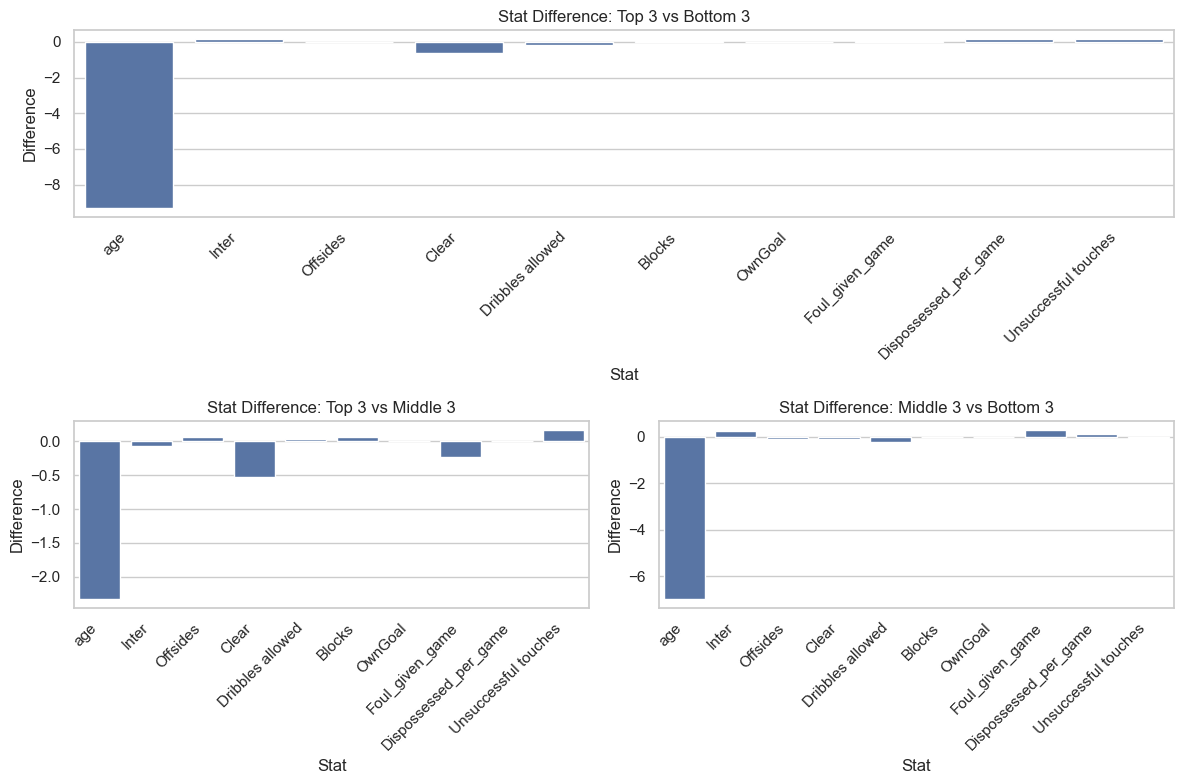

In [12]:
# 상위 3명, 중간 3명, 하위 3명 선수 선택
top_players = similar_players_stats.nlargest(3, 'Market Value')
mid_players = similar_players_stats.iloc[len(similar_players_stats)//2-1:len(similar_players_stats)//2+2]
bottom_players = similar_players_stats.nsmallest(3, 'Market Value')

# 각 그룹의 스탯 평균 계산
top_players_avg = top_players[stat_columns].mean()
mid_players_avg = mid_players[stat_columns].mean()
bottom_players_avg = bottom_players[stat_columns].mean()

# 상위 3명과 하위 3명의 스탯 차이 계산
stat_diff_top_bottom = top_players_avg - bottom_players_avg
stat_diff_top_mid = top_players_avg - mid_players_avg
stat_diff_mid_bottom = mid_players_avg - bottom_players_avg

# 스탯 차이를 데이터프레임으로 변환
stat_diff_df = pd.DataFrame({
    'Stat': stat_columns,
    'Top vs Bottom': stat_diff_top_bottom,
    'Top vs Middle': stat_diff_top_mid,
    'Middle vs Bottom': stat_diff_mid_bottom
})

# 스탯 차이 시각화
plt.figure(figsize=(12, 8))
sns.set(style='whitegrid')

# 상위 3명과 하위 3명의 스탯 차이 바 차트
plt.subplot(2, 1, 1)
sns.barplot(x='Stat', y='Top vs Bottom', data=stat_diff_df)
plt.title('Stat Difference: Top 3 vs Bottom 3')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Stat')
plt.ylabel('Difference')

# 상위 3명과 중간 3명의 스탯 차이 바 차트
plt.subplot(2, 2, 3)
sns.barplot(x='Stat', y='Top vs Middle', data=stat_diff_df)
plt.title('Stat Difference: Top 3 vs Middle 3')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Stat')
plt.ylabel('Difference')

# 중간 3명과 하위 3명의 스탯 차이 바 차트
plt.subplot(2, 2, 4)
sns.barplot(x='Stat', y='Middle vs Bottom', data=stat_diff_df)
plt.title('Stat Difference: Middle 3 vs Bottom 3')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Stat')
plt.ylabel('Difference')

plt.tight_layout()
plt.show()